In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


2025-02-15 10:18:15.290375: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-15 10:18:15.290477: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-15 10:18:15.290524: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-15 10:18:16.776738: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Select 5 Classes for Classification

# Path to the dataset (change if needed)
dataset_path = "food-101/images"

# Get all available class names
all_classes = sorted(os.listdir(dataset_path))  # Sorted for consistency

# Select only 5 classes (modify if needed)
selected_classes = random.sample(all_classes, 5)

print("Selected Classes:", selected_classes)


Selected Classes: ['breakfast_burrito', 'hamburger', 'tuna_tartare', 'chocolate_cake', 'cannoli']


In [3]:
# Data Preprocessing & Augmentation

# Image settings
img_size = (150, 150)  
batch_size = 8  

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,  
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  
)

# Load training data
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    classes=selected_classes,  # Use only selected classes
    subset="training"
)

# Load validation data
val_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    classes=selected_classes,
    subset="validation"
)

num_classes = len(selected_classes)  # Should be 5


Found 4000 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.


In [4]:
# Load Pretrained InceptionV3 & Modify It

# Load InceptionV3 with pretrained ImageNet weights
base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=(150, 150, 3))

# Freeze base model for initial training
base_model.trainable = False  

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)  
x = Dropout(0.5)(x)
output_layer = Dense(num_classes, activation="softmax")(x)  # Output layer with 5 classes

# Create the final model
model = Model(inputs=base_model.input, outputs=output_layer)


In [5]:
# Compile the Model

model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])


In [6]:
# Train the Model with Early Stopping

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

# Reduce learning rate if the model stops improving
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, min_lr=1e-6)

epochs = 20  # Start with 10 epochs
history = model.fit(train_generator, validation_data=val_generator, epochs=epochs, callbacks=[early_stopping, reduce_lr])


Epoch 1/20
500/500 [==============================] - 462s 913ms/step - loss: 1.6177 - accuracy: 0.2167 - val_loss: 1.5915 - val_accuracy: 0.2330 - lr: 1.0000e-04
Epoch 2/20
500/500 [==============================] - 71s 142ms/step - loss: 1.5989 - accuracy: 0.2383 - val_loss: 1.5752 - val_accuracy: 0.3060 - lr: 1.0000e-04
Epoch 3/20
500/500 [==============================] - 71s 142ms/step - loss: 1.5838 - accuracy: 0.2632 - val_loss: 1.5754 - val_accuracy: 0.2480 - lr: 1.0000e-04
Epoch 4/20
500/500 [==============================] - 70s 140ms/step - loss: 1.5770 - accuracy: 0.2695 - val_loss: 1.5547 - val_accuracy: 0.3190 - lr: 1.0000e-04
Epoch 5/20
500/500 [==============================] - 70s 140ms/step - loss: 1.5719 - accuracy: 0.2747 - val_loss: 1.5455 - val_accuracy: 0.3400 - lr: 1.0000e-04
Epoch 6/20
500/500 [==============================] - 72s 143ms/step - loss: 1.5600 - accuracy: 0.2880 - val_loss: 1.5433 - val_accuracy: 0.3270 - lr: 1.0000e-04
Epoch 7/20
500/500 [=======

In [7]:
# Fine-Tune by Unfreezing Some Layers

# Unfreeze last 30 layers for fine-tuning
for layer in model.layers[-30:]:  
    layer.trainable = True

# Compile with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.00001), loss="categorical_crossentropy", metrics=["accuracy"])

# Train again for fine-tuning
fine_tune_epochs = 5
history_fine = model.fit(train_generator, validation_data=val_generator, epochs=fine_tune_epochs, callbacks=[early_stopping, reduce_lr])


Epoch 1/5
500/500 [==============================] - 81s 148ms/step - loss: 3.1819 - accuracy: 0.2755 - val_loss: 1.6035 - val_accuracy: 0.3480 - lr: 1.0000e-05
Epoch 2/5
500/500 [==============================] - 72s 143ms/step - loss: 1.7045 - accuracy: 0.3058 - val_loss: 1.4932 - val_accuracy: 0.3830 - lr: 1.0000e-05
Epoch 3/5
500/500 [==============================] - 75s 149ms/step - loss: 1.6328 - accuracy: 0.3038 - val_loss: 1.4626 - val_accuracy: 0.3980 - lr: 1.0000e-05
Epoch 4/5
500/500 [==============================] - 74s 148ms/step - loss: 1.5659 - accuracy: 0.3203 - val_loss: 1.4594 - val_accuracy: 0.3760 - lr: 1.0000e-05
Epoch 5/5
500/500 [==============================] - 75s 150ms/step - loss: 1.5500 - accuracy: 0.3322 - val_loss: 1.4445 - val_accuracy: 0.3870 - lr: 1.0000e-05


125/125 [==============================] - 14s 109ms/step - loss: 1.4575 - accuracy: 0.4000
Validation Accuracy: 0.40


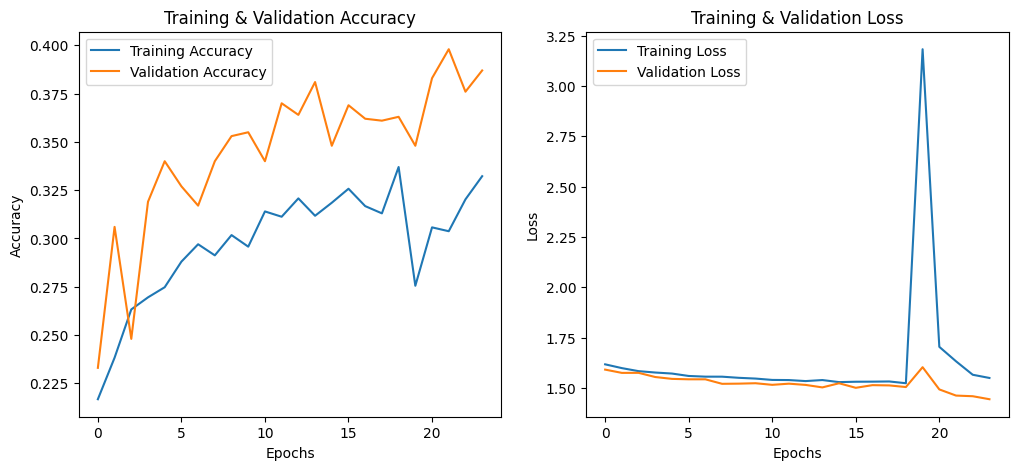

In [8]:
# Evaluate & Plot Accuracy/Loss Graphs

# Evaluate on validation set
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc:.2f}")

# Extract accuracy and loss
train_acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
train_loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']
epochs_range = range(len(train_acc))  # Number of epochs

# Plot accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy graph
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()

# Loss graph
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

plt.show()


In [9]:
# Save the Model for Future Use

model.save("food101_inceptionv3_5classes.h5")

/opt/jupyterhub/pyvenv/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
